# Ocean interior carbon storage: Changes in preformed vs regenerated carbon over the historic period (1850-2014)

In [20]:
%matplotlib inline
import xarray as xr
import intake
import numpy as np
from cmip6_preprocessing.preprocessing import read_data
import warnings
import matplotlib.pyplot as plt

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [21]:
from dask.distributed import Client

client = Client("tcp://10.32.78.130:33357")
client

Client Scheduler: tcp://10.32.78.130:33357 Dashboard: /user/0000-0002-2993-7484/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [23]:
# Functions
def calc_o2sat_gsw(practical_salinity,potential_temperature):
    import gsw
    '''
    #Calculate Absolute Salinity
    gsw_as=xr.apply_ufunc(gsw.SA_from_SP,
                          practical_salinity,
                          pressure,
                          longitude,
                          latitude,
                          dask='parallelized',
                          output_dtypes=[float])
    
    #Calculate Conservative Temperature
    gsw_ct=xr.apply_ufunc(gsw.CT_from_t,
                          gsw_as,
                          potential_temperature,
                          pressure,
                          dask='parallelized',
                          output_dtypes=[float])

    #Calculate Oxygen Saturation
    gsw_o2sat=xr.apply_ufunc(gsw.O2sol,
                             gsw_as,
                             gsw_ct,
                             pressure,
                             longitude,
                             latitude,
                             dask='parallelized',
                             output_dtypes=[float])
    '''
    gsw_o2sat=xr.apply_ufunc(gsw.O2sol_SP_pt,
                             practical_salinity,
                             potential_temperature,
                             dask='parallelized',
                             output_dtypes=[float])
    
    return gsw_o2sat*1.0245e-3 # Convert umol/kg to mol/m3

def get_atl_pac_section_lon(modelid):
    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        xlocp=140
        xloca=275
    elif model == 'CESM2':
        xlocp=210
        xloca=10
    elif model in ('GFDL-CM4','GFDL-ESM4'):
        xlocp=200
        xloca=325
    elif model == 'CESM2-WACCM':
        xlocp=210
        xloca=330    
    else:
        xlocp=125
        xloca=255
    
    return xloca, xlocp

def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [24]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    #col = intake.open_esm_datastore("../catalogs/pangeo-cmip6_update_2019_10_18.json")    
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6-noQC.json")

In [25]:
#import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [26]:
# read all data with dic from regridded models 
#  (Cant use "cmip6_preprocessing.preprocessing.read_data" 
#  because "lon" is not a variable, even though it's a coordinate)
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id = ['historical'], 
                 grid_label    = 'gr',
                 table_id      = 'Omon',
                 variable_id   = 'dissic')
models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models=models-{'GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)
print(models)

# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs ={'chunks':{'time':50}, 'decode_times': False})
dic_dict={}
for model in dset_dict.keys():
    dic_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
    lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
    dic_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
    dic_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
    
# read GISS data with dic from native grid models 
#  (Cant use "cmip6_preprocessing.preprocessing.read_data" 
#  because buffer lengths dont match, or something) 
#cat = col.search(experiment_id = ['historical'], 
#                 grid_label    = 'gn',
#                 table_id      = 'Omon',
#                 variable_id   = 'dissic',
#                 source_id     = ['GISS-E2-1-G-CC','GISS-E2-1-G'])
#
## Load the data
#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
#                                cdf_kwargs ={'chunks':{'time':30}, 'decode_times': False})
#for model in dset_dict.keys():
#    dic_dict[dset_dict[model].source_id]=dset_dict[model].rename({'lon':'x','lat':'y'})
    
# read all data with dic native models
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id = ['historical'], 
                 grid_label    = 'gn',
                 table_id      = 'Omon',
                 variable_id   = 'dissic')
models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
models=models-{'GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)
print(models)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = ['gn'],
                          variable_id   = ['dissic'],
                          table_id      = ['Omon'],
                          source_id     =  models,
                          required_variable_id = ['dissic'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        dic_dict[model]=dset_dict[model]

# Correct CESM2 has depth in cm
dic_dict['CESM2']['lev']=dic_dict['CESM2']['lev']/100

print(dic_dict.keys())

['GFDL-CM4', 'CESM2', 'CESM2-WACCM', 'GFDL-ESM4']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
['UKESM1-0-LL', 'MIROC-ES2L', 'CanESM5', 'IPSL-CM6A-LR', 'CESM2', 'CNRM-ESM2-1']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CESM2
NON-

In [27]:
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id = ['historical'], 
                 grid_label    = ['gr','gn'],
                 table_id      = 'Omon',
                 variable_id   = 'o2')
models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# Find the models that have O2 AND DIC (Norwegian and GISS models excluded)
models   = models.intersection(cat.df.source_id.unique().tolist(),dic_dict.keys())
models_gn= models-{'CESM2-WACCM','GFDL-CM4'}
models   = models-{'CESM2-WACCM','GFDL-CM4'}
models   = list(models)
models_gn= list(models_gn)
print(models)

# read all data with O2 from regridded models 
#  (Cant use "cmip6_preprocessing.preprocessing.read_data" 
#  because "lon" is not a variable, even though it's a coordinate)
bgc_dict={}
cat = col.search(experiment_id  =['historical'],
                 grid_label     = 'gr',
                 variable_id    = 'o2',
                 table_id       = 'Omon')
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs= {'chunks':{'time':50}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        bgc_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        bgc_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        bgc_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with O2 native models
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                         experiment_id = ['historical'],
                         grid_label    = ['gn'],
                         variable_id   = ['o2'],
                         table_id      = ['Omon'],
                         source_id     = models,
                         required_variable_id = ['o2'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            bgc_dict[model]=dset_dict[model]
print(bgc_dict.keys())

# Get DIC into bgc_dict for calculating carbon components
for model in bgc_dict.keys():
    bgc_dict[model]['dissic']=dic_dict[model]['dissic']

['UKESM1-0-LL', 'MIROC-ES2L', 'CanESM5', 'IPSL-CM6A-LR', 'CNRM-ESM2-1']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'U

In [28]:
# read all data with thetao, and so
print(models)
theta_dict={}
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gr',
                 variable_id   = 'thetao',
                 table_id      = 'Omon')
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':50}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        theta_dict[dset_dict[model].source_id]=dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        theta_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        theta_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with theta native models (excluding GFDL, which didnt report O2 on native grid)
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = 'gn',
                          variable_id   = 'thetao',
                          table_id      = 'Omon',
                          source_id     =  models_gn,
                          required_variable_id = ['thetao'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            theta_dict[model]=dset_dict[model]
print(theta_dict.keys())

salt_dict={}
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gr',
                 variable_id   = 'so',
                 table_id      = 'Omon')
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':30}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        salt_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        salt_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        salt_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with dic native models (excluding GFDL, which didnt report O2 on native grid)
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = ['gn'],
                          variable_id   = ['so'],
                          table_id      = ['Omon'],
                          source_id     =  models_gn,
                          required_variable_id = ['so'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            salt_dict[model]=dset_dict[model]
print(salt_dict.keys())

['UKESM1-0-LL', 'MIROC-ES2L', 'CanESM5', 'IPSL-CM6A-LR', 'CNRM-ESM2-1']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'U

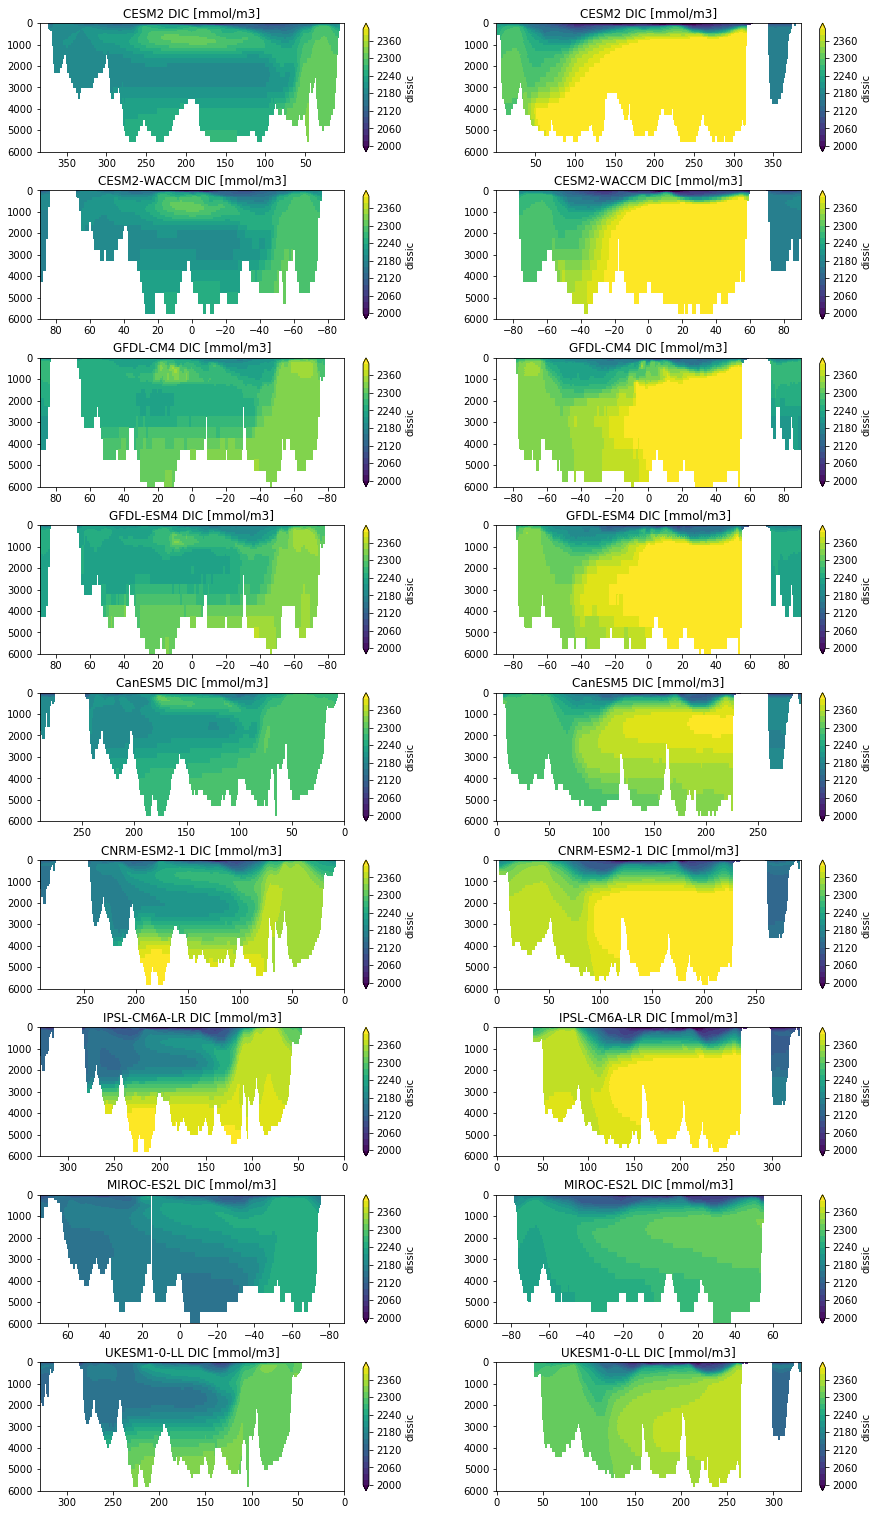

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=len(dic_dict.keys()),figsize=[15, 3*len(dic_dict.keys())])
A = 0
for model in dic_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    (dic_dict[model].dissic.isel(time=slice(-13,-1)).mean({'time','member_id'}).isel(x=xloca)*1e3).plot(
        ax=axes[A,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    (dic_dict[model].dissic.isel(time=slice(-13,-1)).mean({'time','member_id'}).isel(x=xlocp)*1e3).plot(
        ax=axes[A,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" DIC [mmol/m3]")
    
    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,dic_dict[model].dissic.y.min())
        axes[A,1].set_xlim(dic_dict[model].dissic.y.min(),75)
    else:
        axes[A,0].set_xlim(dic_dict[model].dissic.y.max(),dic_dict[model].dissic.y.min())
        
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" DIC [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

## Calculate Saturated Oxygen for each model

In [33]:
for model in bgc_dict.keys():
    print(model)
    bgc_dict[model]['gsw_o2sat']=calc_o2sat_gsw( salt_dict[model]['so'],
                                                theta_dict[model]['thetao'])
                                               #   bgc_dict[model]['lat'],
                                               #   bgc_dict[model]['lon'],
                                               #   bgc_dict[model]['lev'])
    bgc_dict[model]['gsw_o2sat'] =  bgc_dict[model]['gsw_o2sat'].chunk({'time':5})
    bgc_dict[model]['aou']       = (bgc_dict[model]['gsw_o2sat']-bgc_dict[model].o2).chunk({'time':5})
    bgc_dict[model]['creg']      =  bgc_dict[model]['aou'].chunk({'time':5})*(117/170)
    bgc_dict[model]['cpre']      = (bgc_dict[model]['dissic']-bgc_dict[model]['creg']).chunk({'time':5})

CanESM5
CNRM-ESM2-1
IPSL-CM6A-LR
MIROC-ES2L
UKESM1-0-LL


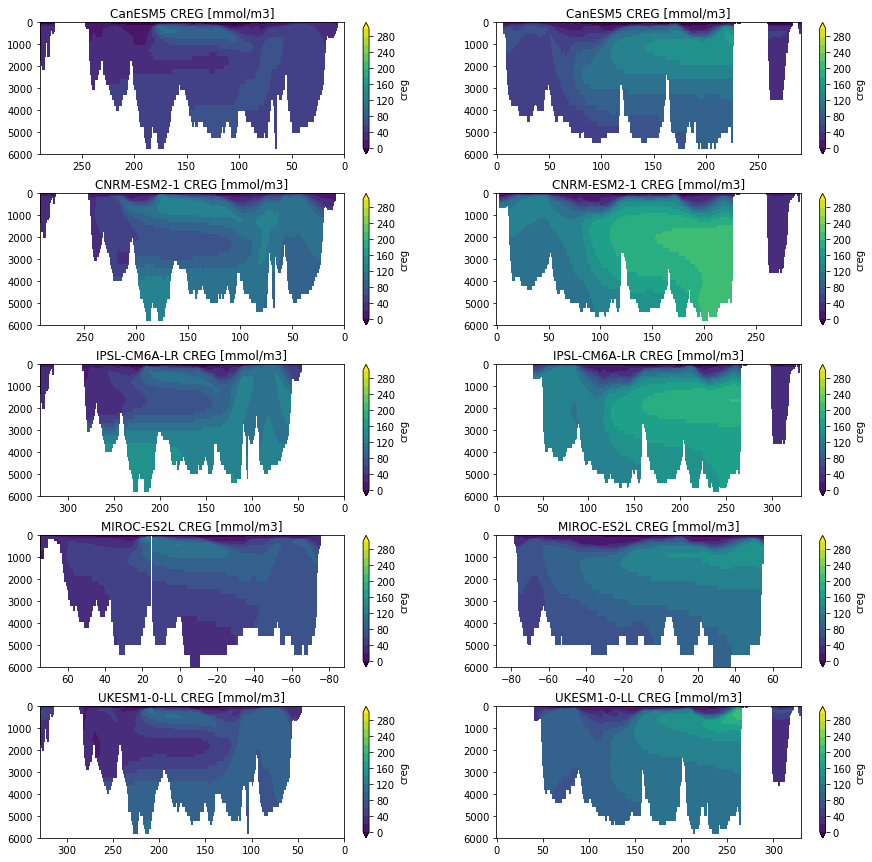

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=len(bgc_dict.keys()),figsize=[15, 3*len(bgc_dict.keys())])
A = 0
for model in bgc_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    (bgc_dict[model].creg.isel(time=slice(-13,-1)).mean('time').mean('member_id').isel(x=xloca)*1e3).plot(
        ax=axes[A,0],levels=np.arange(0,320,20),cmap='viridis',extend="both")
    (bgc_dict[model].creg.isel(time=slice(-13,-1)).mean('time').mean('member_id').isel(x=xlocp)*1e3).plot(
        ax=axes[A,1],levels=np.arange(0,320,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" CREG [mmol/m3]")

    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,bgc_dict[model].o2.y.min())
        axes[A,1].set_xlim(bgc_dict[model].o2.y.min(),75)
    else:
        axes[A,0].set_xlim(bgc_dict[model].o2.y.max(),bgc_dict[model].o2.y.min())
        
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CREG [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

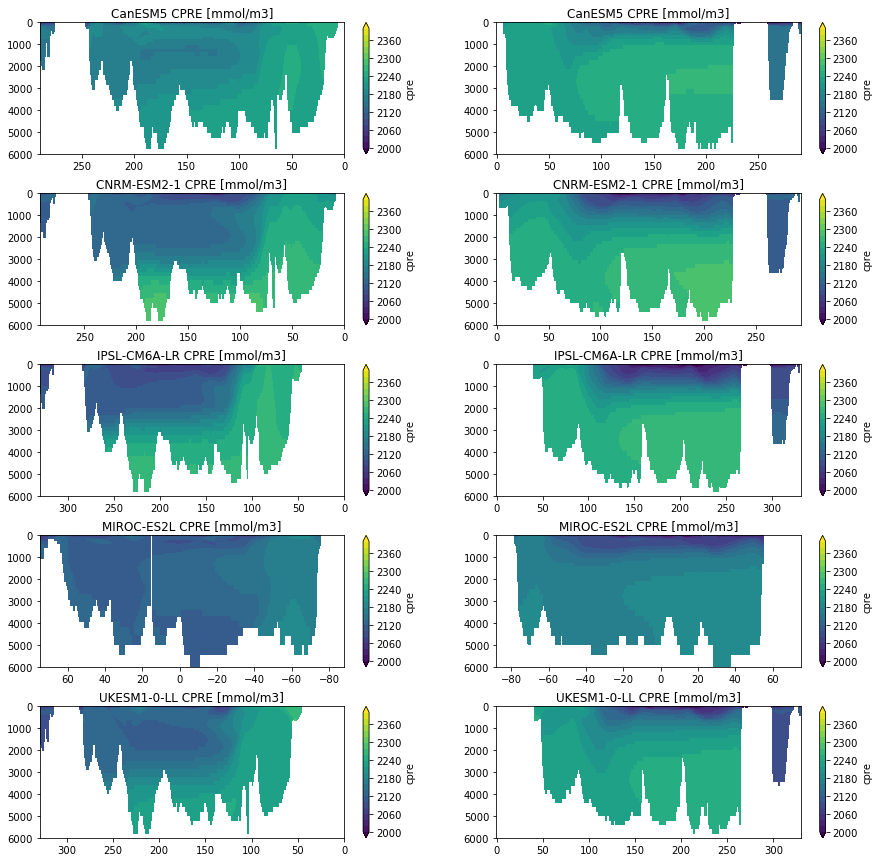

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=len(bgc_dict.keys()),figsize=[15, 3*len(bgc_dict.keys())])
A = 0
for model in bgc_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    (bgc_dict[model].cpre.isel(time=slice(-13,-1)).mean('time').mean('member_id').isel(x=xloca)*1e3).plot(
        ax=axes[A,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    (bgc_dict[model].cpre.isel(time=slice(-13,-1)).mean('time').mean('member_id').isel(x=xlocp)*1e3).plot(
        ax=axes[A,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" CPRE [mmol/m3]")

    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,bgc_dict[model].o2.y.min())
        axes[A,1].set_xlim(bgc_dict[model].o2.y.min(),75)
    else:
        axes[A,0].set_xlim(bgc_dict[model].o2.y.max(),bgc_dict[model].o2.y.min())
        
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CPRE [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

## Compute linear trend in DIC, Cpre, and Creg

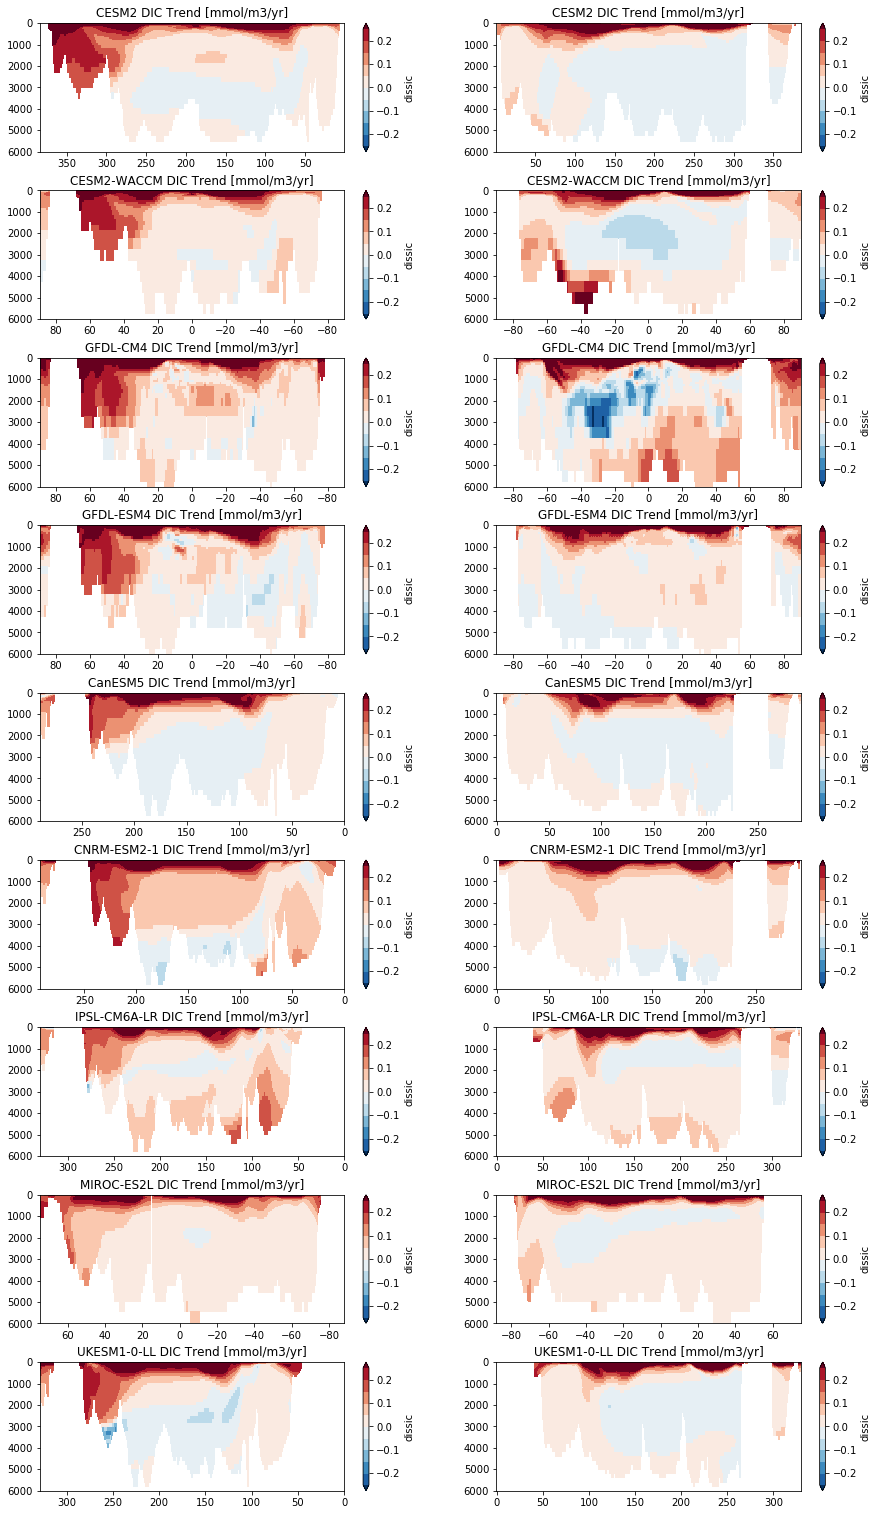

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=len(dic_dict.keys()),figsize=[15, 3*len(dic_dict.keys())])
A = 0
for model in dic_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    aslope = compute_slope(dic_dict[model].dissic.isel(x=xloca)
                           .chunk({'time': -1,'y': 100}))
    aslope = aslope.mean('member_id')*12 # in mol/m^3/year
    
    pslope = compute_slope(dic_dict[model].dissic.isel(x=xlocp)
                           .chunk({'time': -1,'y': 100}))
    pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
    (aslope*1000).plot(ax=axes[A,0],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")
    (pslope*1000).plot(ax=axes[A,1],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")

    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,dic_dict[model].dissic.y.min())
        axes[A,1].set_xlim(dic_dict[model].dissic.y.min(),75)
    else:
        axes[A,0].set_xlim(dic_dict[model].dissic.y.max(),dic_dict[model].dissic.y.min())

    axes[A,0].set_title(model+" DIC Trend [mmol/m3/yr]")
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" DIC Trend [mmol/m3/yr]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

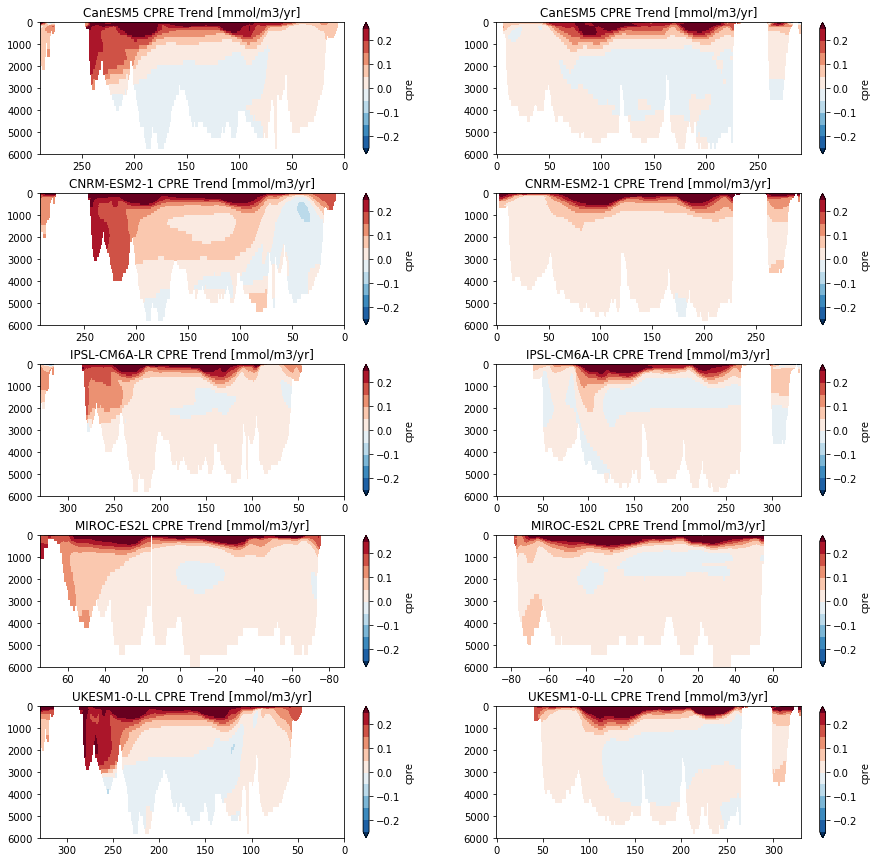

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=len(bgc_dict.keys()),figsize=[15, 3*len(bgc_dict.keys())])
A = 0
for model in bgc_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    aslope = compute_slope(bgc_dict[model].cpre.isel(x=xloca)
                           .chunk({'time': -1,'y': 100}))
    aslope = aslope.mean('member_id')*12 # in mol/m^3/year
    
    pslope = compute_slope(bgc_dict[model].cpre.isel(x=xlocp)
                           .chunk({'time': -1,'y': 100}))
    pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
    (aslope*1000).plot(ax=axes[A,0],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")
    (pslope*1000).plot(ax=axes[A,1],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")

    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,bgc_dict[model].o2.y.min())
        axes[A,1].set_xlim(bgc_dict[model].o2.y.min(),75)
    else:
        axes[A,0].set_xlim(bgc_dict[model].o2.y.max(),bgc_dict[model].o2.y.min())

    axes[A,0].set_title(model+" CPRE Trend [mmol/m3/yr]")
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CPRE Trend [mmol/m3/yr]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

distributed.client - WARNING - Couldn't gather 4 keys, rescheduling {"('xarray-area_t-c43fca5464251d1aae92d43b41431d9c', 2)": ('tcp://10.32.14.48:42789',), "('xarray-dyt-24ff16b8f7d81eba2444987ab4cfd628', 2)": ('tcp://10.32.18.21:46331',), "('xarray-dyt-24ff16b8f7d81eba2444987ab4cfd628', 0)": ('tcp://10.32.18.21:46331',), "('xarray-dyt-24ff16b8f7d81eba2444987ab4cfd628', 1)": ('tcp://10.32.18.21:46331',)}


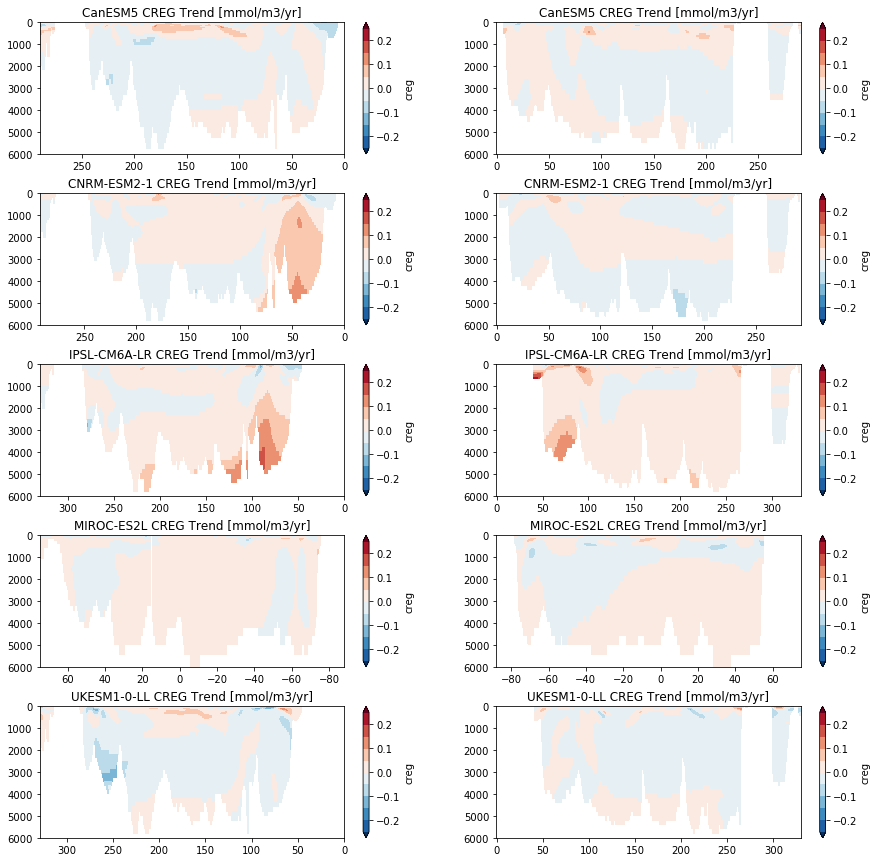

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=len(bgc_dict.keys()),figsize=[15, 3*len(bgc_dict.keys())])
A = 0
for model in bgc_dict.keys():
    xloca, xlocp = get_atl_pac_section_lon(model)
    
    aslope = compute_slope(bgc_dict[model].creg.isel(x=xloca)
                           .chunk({'time': -1,'y': 100}))
    aslope = aslope.mean('member_id')*12 # in mol/m^3/year
    
    pslope = compute_slope(bgc_dict[model].creg.isel(x=xlocp)
                           .chunk({'time': -1,'y': 100}))
    pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
    (aslope*1000).plot(ax=axes[A,0],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")
    (pslope*1000).plot(ax=axes[A,1],cmap='RdBu_r',levels=np.arange(-0.25,0.30,0.05),extend="both")

    if model == 'MIROC-ES2L':
        # This model is half Arctic!!
        axes[A,0].set_xlim(75,bgc_dict[model].o2.y.min())
        axes[A,1].set_xlim(bgc_dict[model].o2.y.min(),75)
    else:
        axes[A,0].set_xlim(bgc_dict[model].o2.y.max(),bgc_dict[model].o2.y.min())

    axes[A,0].set_title(model+" CREG Trend [mmol/m3/yr]")
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CREG Trend [mmol/m3/yr]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)